In [1]:
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

import pickle

import mountain
import gymnasium

from copy import deepcopy

# Part 2 - Report

### Exercise 5

Let's load the trajectories and perform Monte Carlo evaluation to find $v_\pi(s)$ and $q_\pi(a, s)$.

In [2]:
# Load the trajectories
f = open("trajectories.pickle", "rb")
trajectories = pickle.load(f)
f.close()

In [3]:
print(trajectories[0][:5])

[((15, 0), 0, -0.5058824, (14, 0)), ((14, 0), 6, -0.5058824, (14, 0)), ((14, 0), 5, -0.5058824, (15, 1)), ((15, 1), 3, -0.5058824, (16, 0)), ((16, 0), 3, -0.5058824, (17, 0))]


In [4]:
# Store v_π and q_π in respective arrays
rows, columns = 32, 100
v_π = np.array([[0 for _ in range(columns)] for _ in range(rows)])
q_π = np.array([[[0 for _ in range(8)] for _ in range(columns)] for _ in range(rows)])

# Let's choose a discount factor gamma of 0.99
gamma = 0.99

# Store number of times trajectories go through each state
N_s = np.zeros_like(v_π)
N_as = np.zeros_like(q_π)

# Compute these respective values from the given trajectories
for trajectory in trajectories:
    # Iterate trajectory back-to-front
    G_τ = 0
    for start_state, action, reward, end_state in reversed(trajectory):
        N_s[start_state] += 1
        N_as[start_state][action] += 1

        G_τ = reward + gamma * G_τ
        v_π[start_state] += (G_τ - v_π[start_state]) / N_s[start_state]
        q_π[start_state][action] += (G_τ - q_π[start_state][action]) / N_as[start_state][action]

Let's now plot the state-value function $v_\pi(s)$.

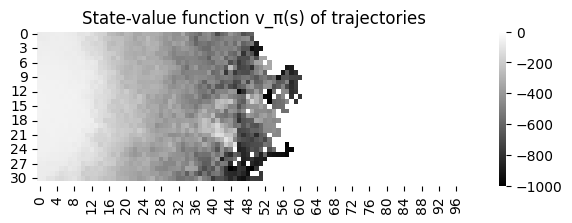

In [5]:
# Let's plot the values as a heatmap
plt.figure(figsize=(7,2))
sns.heatmap(v_π, cmap="gray")
plt.title("State-value function v_π(s) of trajectories")
plt.show()

------------------------------------------
### 4. (*)

We can see that no trajectory got more than halfway down the mountain. As every value on the right is 0, it indicates they are unexplored. This will be a problem as we can not compute an evaluation for the whole map, meaning we again can not calculate an optimal policy for the whole map.

------------------------------------------

------------------------------------------
### 5. (*)

Yes we can perform MC improvement, as the only thing we need for that is the state-action evaluation $q_\pi(a, s)$, which we computed above. However, the new policy cannot possibly be optimal as we have not explored enough of the map. 

------------------------------------------

------------------------------------------
### 6. (*)

No. To do MC control we need a way to generate new trajectories, which we cannot do here.

------------------------------------------

------------------------------------------
### 7. (*)

We already have computed the state-action evaluation $q_\pi(a, s)$ from the same environment as the one we've been given. However, as that evaluation is incomplete (only reached halfway) there would be no gain from using it to initialize our policy. That is because, as no trajectory reached the end, all routes will become more and more negative the further down the map we come. And thus, using this as out starting point will lead to our policy wanting to move left, back towards the start (as here, the values are less negative).

Therefore, it would be best to randomize the starting policy π and "restart".

------------------------------------------

Let's create this policy, aswell as instantiate and run the simulator for the environment through gymnasium.

In [6]:
# Instantiate the environment
env = gymnasium.make('mountain/GridWorld-v0')

rows, columns = env.height, env.width

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.height to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.height` for environment variables or `env.get_wrapper_attr('height')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.width to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.width` for environment variables or `env.get_wrapper_attr('width')` that will search the reminding wrappers.
  logger.warn(


In [7]:
# Create the policy
π = np.ones_like(v_π)

for row in range(rows):
    for column in range(columns):
        # Randomize starting policy
        π[row, column] = np.random.randint(8)

We can now perform MC control and learn the optimal policy for the robot through $\epsilon$-greedy.

In [8]:
# For ε-greedy, set epsilon to 0.8, alpha_decay to 0.99 and gamma to 0.99
epsilon = 0.8
alpha_decay = 0.99
gamma =  0.99

# Let's also train each model for 100 000 episodes
episodes = 100_000

In [9]:
# Store evaluation
v_π = np.array([[0 for _ in range(columns)] for _ in range(rows)])
q_π = np.array([[[0 for _ in range(8)] for _ in range(columns)] for _ in range(rows)])
N_s = np.zeros_like(v_π)
N_as = np.zeros_like(q_π)

# Store copy to know when policy converges
π_copy = np.zeros_like(π)

# Perform MC ε-greedy control algorithm
iterations = 0
while iterations < episodes:
    iterations += 1
    π_copy = deepcopy(π)

    # First generate a trajectory
    trajectory = []
    observation, info = env.reset()
    terminated = truncated = False
    while not (terminated or truncated):
        state = (observation["agent"]["pos"][0], observation["agent"]["pos"][1])
        action = π[state]
        observation, reward, terminated, truncated, info = env.step(action)

        end_state = (observation["agent"]["pos"][0], observation["agent"]["pos"][1])
        trajectory.append((state, action, reward, end_state))
    
    # Then update q_π using MC prediction
    G_τ = 0
    for start_state, action, reward, end_state in reversed(trajectory):
        N_s[start_state] += 1
        N_as[start_state][action] += 1

        G_τ = reward + gamma * G_τ
        v_π[start_state] += (G_τ - v_π[start_state]) / N_s[start_state]
        q_π[start_state][action] += (G_τ - q_π[start_state][action]) / N_as[start_state][action]

    # At last, perform ε-greedy improvement
    for row in range(rows):
        for column in range(columns):
            if np.random.uniform() < 1 - epsilon:
                π[row, column] = np.argmax(q_π[row, column])
            else:
                π[row, column] = np.random.randint(8)
    
    # At last, decay epsilon 
    epsilon *= alpha_decay

env.close()
print("Policy π converged after", iterations, "iterations.")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be int32, actual type: int64
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be int32, actual type: int64
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not wit

Policy π converged after 100000 iterations.


Let's visualize the policy and see if we've found an optimal one.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.MAP to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.MAP` for environment variables or `env.get_wrapper_attr('MAP')` that will search the reminding wrappers.
  logger.warn(


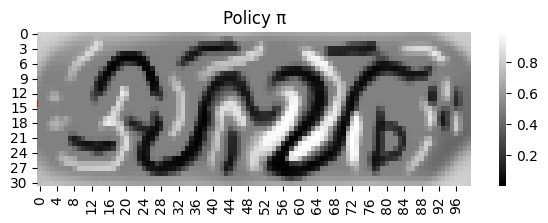

In [10]:
trajectory = []
observation, info = env.reset()
terminated = truncated = False
while not (terminated or truncated):
    # Perform current policy's action from state
    state = (observation["agent"]["pos"][0], observation["agent"]["pos"][1])
    action = π[state]
    observation, reward, terminated, truncated, info = env.step(action)

    # Record new state and action
    new_state = (observation["agent"]["pos"][0], observation["agent"]["pos"][1])
    trajectory.append(state)

# Let's plot the values as a heatmap
plt.figure(figsize=(7,2))
sns.heatmap(env.MAP, cmap="gray")
plt.plot(np.array(trajectory)[:, 1], np.array(trajectory)[:, 0], c="r")
plt.title("Policy π")
plt.show()

If we visualize the trajectory we can see it spins back and fourth right from the start. Let's visualize the compute state-value evaluation aswell.

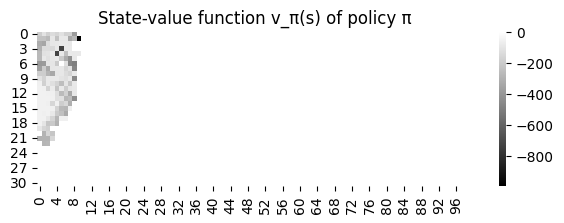

In [11]:
# Let's plot the values as a heatmap
plt.figure(figsize=(7,2))
sns.heatmap(v_π, cmap="gray")
plt.title("State-value function v_π(s) of policy π")
plt.show()

As we can see we have not even explored an eighth of the map!

------------------------------------------
### 9. (*)

No, we did not manage to learn an optimal policy. As we can see from the plot above, we did not even manage to explore an eighth of the map. It is obvious that the challenge with Monte Carlo here is that we never terminate. When performing random moves in an environment as large as this, it is very difficult to reach the end. This will lead to the robot going back and fourth a lot, and thus never exploring further areas.

------------------------------------------

Now let's try implementing SARSA to learn the optimal policy for the robot.

In [12]:
env = gymnasium.make('mountain/GridWorld-v0')

# Again start with a randomized starting policy
π_sarsa = np.array([[np.random.randint(8) for _ in range(columns)] for _ in range(rows)])

# For SARSA we need an new alpha value of 0.15 (other than decay)
alpha_sarsa = 0.15

epsilon = 0.8
alpha_decay = 0.99

In [13]:
# Now let's perform SARSA control
q_π_sarsa = np.array([[[0 for _ in range(8)] for _ in range(columns)] for _ in range(rows)])

# SARSA for control
iterations = 0
while iterations < episodes:
    iterations += 1

    # SARSA(0)
    for episode in range(1):
        trajectory = []
        observation, info = env.reset()
        terminated = truncated = False
        while not (terminated or truncated):
            # Perform current policy's action from state
            state = (observation["agent"]["pos"][0], observation["agent"]["pos"][1])
            action = π_sarsa[state]
            observation, reward, terminated, truncated, info = env.step(action)

            # Record new state and action
            new_state = (observation["agent"]["pos"][0], observation["agent"]["pos"][1])
            new_action = π_sarsa[new_state]

            # Compute error and update state-action-value
            delta_π_sarsa = reward + gamma * q_π_sarsa[new_state][new_action] - q_π_sarsa[state][action]
            q_π_sarsa[state][action] += alpha_sarsa * delta_π_sarsa
                
    # Greedy improvement
    for row in range(rows):
        for column in range(columns):
            if np.random.uniform() < 1 - epsilon:
                π_sarsa[row, column] = np.argmax(q_π_sarsa[row, column])
            else:
                π_sarsa[row, column] = np.random.randint(8)
    
    # At last, decay epsilon 
    epsilon *= alpha_decay

env.close()
print("Policy π_sarsa converged after", iterations, "iterations.")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be int32, actual type: int64
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be int32, actual type: int64
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not wit

Policy π_sarsa converged after 100000 iterations.


Let's visualize this policy as well.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.MAP to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.MAP` for environment variables or `env.get_wrapper_attr('MAP')` that will search the reminding wrappers.
  logger.warn(


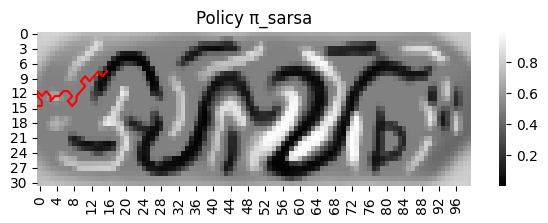

In [14]:
trajectory_sarsa = []
observation, info = env.reset()
terminated = truncated = False
while not (terminated or truncated):
    # Perform current policy's action from state
    state = (observation["agent"]["pos"][0], observation["agent"]["pos"][1])
    action = π_sarsa[state]
    observation, reward, terminated, truncated, info = env.step(action)

    # Record new state and action
    new_state = (observation["agent"]["pos"][0], observation["agent"]["pos"][1])
    trajectory_sarsa.append(state)
trajectory_sarsa.append(new_state)

# Let's plot the values as a heatmap
plt.figure(figsize=(7,2))
sns.heatmap(env.MAP, cmap="gray")
plt.plot(np.array(trajectory_sarsa)[:, 1], np.array(trajectory_sarsa)[:, 0], c="r")
plt.title("Policy π_sarsa")
plt.show()

Let's run both policies, recording the distance from target at the end.

In [15]:
# MC
observation, info = env.reset()
terminated = truncated = False
while not (terminated or truncated):
    # Perform current policy's action from state
    state = (observation["agent"]["pos"][0], observation["agent"]["pos"][1])
    action = π[state]
    observation, reward, terminated, truncated, info = env.step(action)
print("MC final distance from target:", info["distance"])

# SARSA(0)
observation, info = env.reset()
terminated = truncated = False
while not (terminated or truncated):
    # Perform current policy's action from state
    state = (observation["agent"]["pos"][0], observation["agent"]["pos"][1])
    action = π_sarsa[state]
    observation, reward, terminated, truncated, info = env.step(action)
print("SARSA(0) final distance from target:", info["distance"])

MC final distance from target: 99
SARSA(0) final distance from target: 84


------------------------------------------
### 11. (*)

The most meaningful and appropriate metric to compare the two learning processes (MC and SARSA(0)) would probably be a measure which takes into account how well it has started learning moving towards the goal. As neither policy reached the goal, we can choose to use distance from the target at the end as out measure. This would mean the policy which ended closest is appropriately chosen as the best.

As we can see, MC ended with a final distance of $99$, whilst SARSA(0) ended with a final distance of $84$. Therefore, we measure SARSA(0) to be the better one for this task.

------------------------------------------

Let's implement SARSA(n) as a function, and learn different policies with differing values of n.

In [16]:
def SARSA_n(n, q_π, π, env):
    # First generate the a trajectory
    trajectory = []
    observation, info = env.reset()
    terminated = truncated = False
    while not (terminated or truncated):
        state = (observation["agent"]["pos"][0], observation["agent"]["pos"][1])
        action = π[state]
        observation, reward, terminated, truncated, info = env.step(action)

        end_state = (observation["agent"]["pos"][0], observation["agent"]["pos"][1])
        trajectory.append((state, action, reward, end_state))
        
    # Then use SARSA(n) to esimate q_π
    for i in range(len(trajectory)):
        delta_π_sarsa = 0
        for j in reversed(range(i, end := min(i+n+1, len(trajectory)))):
            state, action, reward, end_state = trajectory[j]
                
            if j == end:
                end_action = π[end_state]
                delta_π_sarsa -= q_π[end_state][end_action]
            delta_π_sarsa = reward + gamma * delta_π_sarsa
            if j == i:
                delta_π_sarsa -= q_π[state][action]

        state, action, _, _ = trajectory[i]
        q_π[state][action] += alpha_sarsa * delta_π_sarsa

    # Return the modified state-action-value
    return q_π

Let's train for $n=3$, $n=5$ or $n=10$.

In [17]:
env = gymnasium.make('mountain/GridWorld-v0')

# Again start with a randomized starting policy
π_sarsa_5 = np.array([[np.random.randint(8) for _ in range(columns)] for _ in range(rows)])
π_sarsa_20 = np.array([[np.random.randint(8) for _ in range(columns)] for _ in range(rows)])
π_sarsa_50 = np.array([[np.random.randint(8) for _ in range(columns)] for _ in range(rows)])


# SARSA(3)
iterations = 0
epsilon = 0.8
q_π_sarsa = np.array([[[0 for _ in range(8)] for _ in range(columns)] for _ in range(rows)])
while iterations < episodes:
    iterations += 1
    # Evaluation
    q_π_sarsa = SARSA_n(5, q_π_sarsa, π_sarsa_5, env)
               
    # Greedy improvement
    for row in range(rows):
        for column in range(columns):
            if np.random.uniform() < 1 - epsilon:
                π_sarsa_5[row, column] = np.argmax(q_π_sarsa[row, column])
            else:
                π_sarsa_5[row, column] = np.random.randint(8)
    
    # At last, decay epsilon 
    epsilon *= alpha_decay

# SARSA(5)
iterations = 0
epsilon = 0.8
q_π_sarsa = np.array([[[0 for _ in range(8)] for _ in range(columns)] for _ in range(rows)])
while iterations < episodes:
    iterations += 1
    # Evaluation
    q_π_sarsa = SARSA_n(20, q_π_sarsa, π_sarsa_20, env)
                
    # Greedy improvement
    for row in range(rows):
        for column in range(columns):
            if np.random.uniform() < 1 - epsilon:
                π_sarsa_20[row, column] = np.argmax(q_π_sarsa[row, column])
            else:
                π_sarsa_20[row, column] = np.random.randint(8)
    
    # At last, decay epsilon 
    epsilon *= alpha_decay

# SARSA(10)
iterations = 0
epsilon = 0.8
q_π_sarsa = np.array([[[0 for _ in range(8)] for _ in range(columns)] for _ in range(rows)])
while iterations < episodes:
    iterations += 1
    # Evaluation
    q_π_sarsa = SARSA_n(50, q_π_sarsa, π_sarsa_50, env)
                
    # Greedy improvement
    for row in range(rows):
        for column in range(columns):
            if np.random.uniform() < 1 - epsilon:
                π_sarsa_50[row, column] = np.argmax(q_π_sarsa[row, column])
            else:
                π_sarsa_50[row, column] = np.random.randint(8)
    
    # At last, decay epsilon 
    epsilon *= alpha_decay

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be int32, actual type: int64
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be int32, actual type: int64
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not wit

Then visualize all the different policies on top of eachother.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.MAP to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.MAP` for environment variables or `env.get_wrapper_attr('MAP')` that will search the reminding wrappers.
  logger.warn(


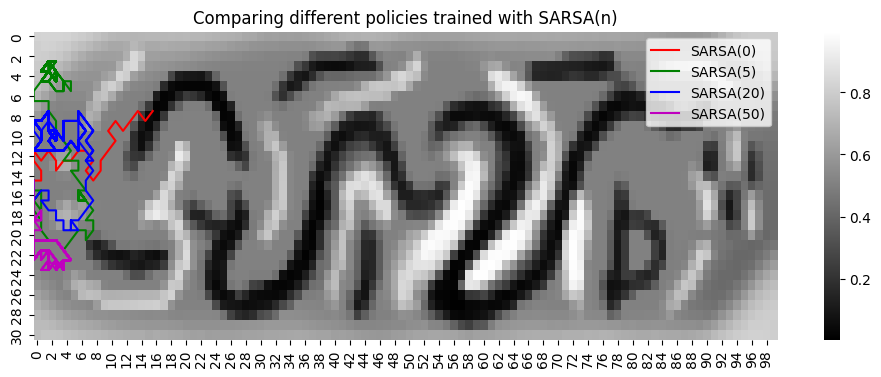

In [18]:
policies = [π_sarsa, π_sarsa_5, π_sarsa_20, π_sarsa_50]
trajectories = []

for policy in policies:
    trajectory = []
    observation, info = env.reset()
    terminated = truncated = False
    while not (terminated or truncated):
        # Perform current policy's action from state
        state = (observation["agent"]["pos"][0], observation["agent"]["pos"][1])
        action = policy[state]
        observation, reward, terminated, truncated, info = env.step(action)

        # Record new state and action
        new_state = (observation["agent"]["pos"][0], observation["agent"]["pos"][1])
        trajectory.append(state)
    trajectory.append(new_state)
    trajectories.append(trajectory)



# Let's plot the values as a heatmap
plt.figure(figsize=(12, 4))
sns.heatmap(env.MAP, cmap="gray")
plt.plot(np.array(trajectories[0])[:, 1], np.array(trajectories[0])[:, 0], c="r", label="SARSA(0)")
plt.plot(np.array(trajectories[1])[:, 1], np.array(trajectories[1])[:, 0], c="g", label="SARSA(5)")
plt.plot(np.array(trajectories[2])[:, 1], np.array(trajectories[2])[:, 0], c="b", label="SARSA(20)")
plt.plot(np.array(trajectories[3])[:, 1], np.array(trajectories[3])[:, 0], c="m", label="SARSA(50)")
plt.title("Comparing different policies trained with SARSA(n)")
plt.legend()
plt.show()

After plotting the different policies, let's also measure their final distance from target.

In [19]:
# SARSA(5)
observation, info = env.reset()
terminated = truncated = False
while not (terminated or truncated):
    # Perform current policy's action from state
    state = (observation["agent"]["pos"][0], observation["agent"]["pos"][1])
    action = π_sarsa_5[state]
    observation, reward, terminated, truncated, info = env.step(action)
print("SARSA(5) final distance from target:", info["distance"])

# SARSA(20)
observation, info = env.reset()
terminated = truncated = False
while not (terminated or truncated):
    # Perform current policy's action from state
    state = (observation["agent"]["pos"][0], observation["agent"]["pos"][1])
    action = π_sarsa_20[state]
    observation, reward, terminated, truncated, info = env.step(action)
print("SARSA(20) final distance from target:", info["distance"])

# SARSA(50)
observation, info = env.reset()
terminated = truncated = False
while not (terminated or truncated):
    # Perform current policy's action from state
    state = (observation["agent"]["pos"][0], observation["agent"]["pos"][1])
    action = π_sarsa_50[state]
    observation, reward, terminated, truncated, info = env.step(action)
print("SARSA(50) final distance from target:", info["distance"])

SARSA(5) final distance from target: 97
SARSA(20) final distance from target: 96
SARSA(50) final distance from target: 98


------------------------------------------
### 13. (*)

Let's choose the same metric as we used when comparing MC and SARSA(0).

From previously, we had that the best policy was SARSA(0), with a final distance of $84$. Here we have that SARSA(5) has $97$, whilst both SARSA(20) had $96$ and SARSA(50) had $98$. This would mean that, again, SARSA(0) is the best performing policy.

This makes sense, as the higher n we have for SARSA(n), the closer we get to MC. As MC apparently did not perform very well on this task, we should not expect SARSA(n) to do so either. (At least not better than SARSA(0)).

------------------------------------------

Let's now implement Q-learning and try to learn the optimal policy for the robot.

In [20]:
π_Q = np.array([[np.random.randint(8) for _ in range(columns)] for _ in range(rows)])

# Q-learning
iterations = 0
epsilon = 0.35
q_π_Q = np.array([[[-1e6 for _ in range(8)] for _ in range(columns)] for _ in range(rows)])
while iterations < episodes:
    iterations += 1

    # Evaluation
    observation, info = env.reset()
    terminated = truncated = False
    while not (terminated or truncated):
        state = (observation["agent"]["pos"][0], observation["agent"]["pos"][1])
        action = π_Q[state] if np.random.uniform() < (1 - epsilon) else np.random.randint(8)

        observation, reward, terminated, truncated, info = env.step(action)
        new_state = (observation["agent"]["pos"][0], observation["agent"]["pos"][1])
        
        delta_π_Q = reward + gamma * np.max(q_π_Q[new_state]) - q_π_Q[state][action]
        q_π_Q[state][action] += alpha_sarsa * delta_π_Q
    
                
    # Improvement
    for row in range(rows):
        for column in range(columns):
            π_Q[row, column] = np.argmax(q_π_Q[row, column])

Finally, we visualize this policies trajectory as well.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.MAP to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.MAP` for environment variables or `env.get_wrapper_attr('MAP')` that will search the reminding wrappers.
  logger.warn(


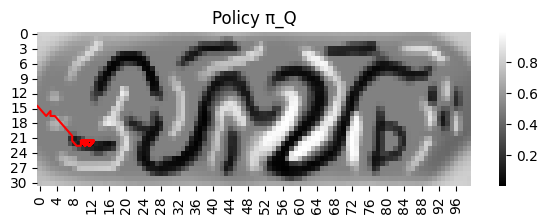

In [21]:
trajectory_Q = []
observation, info = env.reset()
terminated = truncated = False
while not (terminated or truncated):
    # Perform current policy's action from state
    state = (observation["agent"]["pos"][0], observation["agent"]["pos"][1])
    action = π_Q[state]
    observation, reward, terminated, truncated, info = env.step(action)

    # Record new state and action
    new_state = (observation["agent"]["pos"][0], observation["agent"]["pos"][1])
    trajectory_Q.append(state)
trajectory_Q.append(new_state)

# Let's plot the values as a heatmap
plt.figure(figsize=(7,2))
sns.heatmap(env.MAP, cmap="gray")
plt.plot(np.array(trajectory_Q)[:, 1], np.array(trajectory_Q)[:, 0], c="r")
plt.title("Policy π_Q")
plt.show()

Again we measure the final distance from target.

In [22]:
# Q-learning
observation, info = env.reset()
terminated = truncated = False
while not (terminated or truncated):
    # Perform current policy's action from state
    state = (observation["agent"]["pos"][0], observation["agent"]["pos"][1])
    action = π_Q[state]
    observation, reward, terminated, truncated, info = env.step(action)
print("Q-learning final distance from target:", info["distance"])

Q-learning final distance from target: 89


------------------------------------------
### 15. (*)

Comparing Q-learning to the other SARSA policies we see that it did very good in comparison to SARSA(n)! It ended with a final distance of $89$, which is way closer to SARSA(0)'s $84$.
However, as SARSA(0) still had the lowest final distance, this is our current optimal policy.

Inspecting the plots, we see that both SARSA(0) and Q-learning were the only algorithms to learn a reasonable path away from the start. We can see that they learned different paths, but Q-learning seemed to get stuck in a different place, compared to SARSA(0).

------------------------------------------